In [1]:
import os
from fair import FAIR
from fair.io import read_properties
from fair.interface import initialise
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl

/Users/bensan/explore-extensions/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
f = FAIR()

In [3]:
f.define_time(1750, 2501, 1)
f.define_scenarios(["high-extension", "high-overshoot", "medium-extension", "medium-overshoot", "low", "verylow", "verylow-overshoot"])
species, properties = read_properties('../data/fair-parameters/species_configs_properties_1.4.1.csv')
f.define_species(species, properties)
f.ch4_method='Thornhill2021'
df_configs = pd.read_csv('../data/fair-parameters/calibrated_constrained_parameters_1.4.1.csv', index_col=0)
f.define_configs(df_configs.index)
f.allocate()

In [4]:
scens=f.emissions.scenario.values

In [5]:
colors = {
    'high-extension': '#800000',
    'high-overshoot': '#ff0000',
    'medium-extension': '#c87820',
    'medium-overshoot': '#d3a640',
    'low': '#098740',
    'verylow': '#0080d0',
    'verylow-overshoot': '#100060',
}

In [6]:
os.makedirs('../plots', exist_ok=True)

In [7]:
df_emis = pd.read_csv('../data/emissions/extensions_1750-2500.csv')
gwpmat=df_emis.loc[df_emis.scenario=='verylow-overshoot'].set_index('variable')['ar6_gwp_mass_adjusted']

In [8]:
sdict={}
sdict['high-extension']=[[2125,2175,2275],[np.NaN,72,0]]
sdict['high-overshoot']=[[2125,2175,2230,2260],[np.NaN,-28,-28,0]]
sdict['medium-extension']=[[2125,2200],[np.NaN,0]]
sdict['medium-overshoot']=[[2040,2100,2225,2250],[np.NaN,-20,-20,0]]
sdict['low']=[[2050,2075,2105,2180,2200],[np.NaN,0,-5,-5,0]]
sdict['verylow']=[[2125,2225,2275],[np.NaN,-10,0]]
sdict['verylow-overshoot']=[[2125,2150,2250,2275],[np.NaN,-25,-25,0]]


In [9]:
ch4dict={}
ch4dict['high-extension']=[[2200,2250],[np.NaN,50]]
ch4dict['high-overshoot']=[[2125,2175],[np.NaN,160]]
ch4dict['medium-extension']=[[2300],[np.NaN]]
ch4dict['medium-overshoot']=[[2300],[np.NaN]]
ch4dict['low']=[[2300],[np.NaN]]
ch4dict['verylow']=[[2300],[np.NaN]]
ch4dict['verylow-overshoot']=[[2300],[np.NaN]]

In [10]:
n2odict={}
n2odict['high-extension']=[[2200,2250],[np.NaN,6]]
n2odict['high-overshoot']=[[2125,2175],[np.NaN,10]]
n2odict['medium-extension']=[[2300],[np.NaN]]
n2odict['medium-overshoot']=[[2300],[np.NaN]]
n2odict['low']=[[2300],[np.NaN]]
n2odict['verylow']=[[2300],[np.NaN]]
n2odict['verylow-overshoot']=[[2125,2200],[np.NaN,2]]

In [11]:
f.fill_from_csv(
    emissions_file='../data/emissions/extensions_1750-2500.csv',
    forcing_file='../data/forcing/volcanic_solar.csv',
)
for s in scens:
    corescen=f.emissions.sel(scenario=s, specie='CO2 FFI',config=1234).where(f.emissions.timepoints<=sdict[s][0][0], drop=True)
    histtim=f.emissions.timepoints.where(f.emissions.timepoints<=sdict[s][0][0], drop=True)
    tmpf=f.emissions.sel(scenario=s, specie='CO2 FFI',config=1234).copy()
    tmpf[:]=(f.emissions.timepoints,np.interp(f.emissions.timepoints,np.hstack([histtim,sdict[s][0][1:]]),np.hstack([corescen,sdict[s][1][1:]])))[1]
    f.emissions.sel(scenario=s, specie='CO2 FFI').loc[:,:]=tmpf
for s in scens:
    corescen=f.emissions.sel(scenario=s, specie='CH4',config=1234).where(f.emissions.timepoints<=ch4dict[s][0][0], drop=True)
    histtim=f.emissions.timepoints.where(f.emissions.timepoints<=ch4dict[s][0][0], drop=True)
    tmpf=f.emissions.sel(scenario=s, specie='CH4',config=1234).copy()
    tmpf[:]=(f.emissions.timepoints,np.interp(f.emissions.timepoints,np.hstack([histtim,ch4dict[s][0][1:]]),np.hstack([corescen,ch4dict[s][1][1:]])))[1]
    f.emissions.sel(scenario=s, specie='CH4').loc[:,:]=tmpf
for s in scens:
    corescen=f.emissions.sel(scenario=s, specie='N2O',config=1234).where(f.emissions.timepoints<=n2odict[s][0][0], drop=True)
    histtim=f.emissions.timepoints.where(f.emissions.timepoints<=n2odict[s][0][0], drop=True)
    tmpf=f.emissions.sel(scenario=s, specie='N2O',config=1234).copy()
    tmpf[:]=(f.emissions.timepoints,np.interp(f.emissions.timepoints,np.hstack([histtim,n2odict[s][0][1:]]),np.hstack([corescen,n2odict[s][1][1:]])))[1]
    f.emissions.sel(scenario=s, specie='N2O').loc[:,:]=tmpf

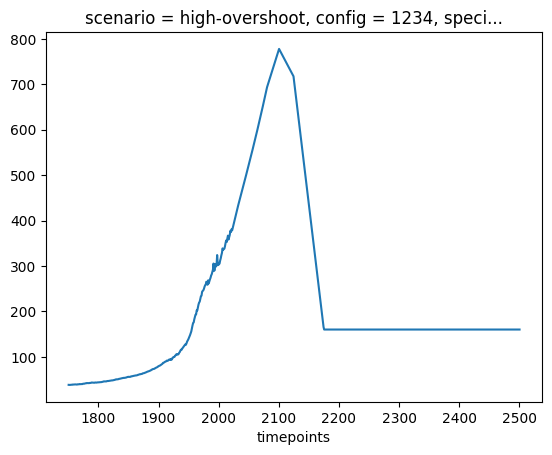

In [12]:
f.emissions.sel(scenario='high-overshoot').loc[dict(specie='CH4')][:,0].plot()

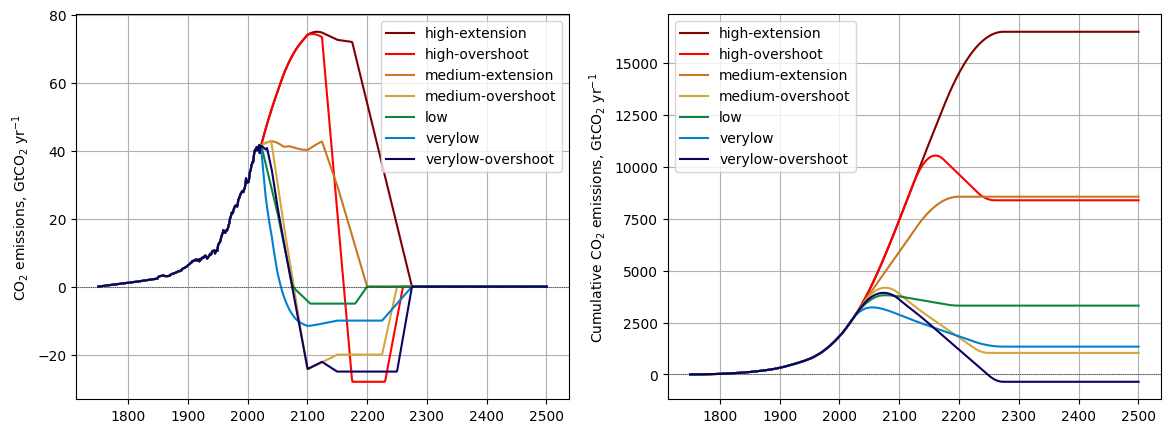

In [13]:
fig, ax = pl.subplots(nrows=1,ncols=2,figsize=(14,5))
for scenario in f.scenarios:
    ax[0].plot(
        f.timepoints,
        (
            f.emissions.sel(scenario=scenario, specie="CO2 FFI", config=f.configs[0]) +
            f.emissions.sel(scenario=scenario, specie="CO2 AFOLU", config=f.configs[0])
        ),
        label=scenario,
        color=colors[scenario]
    )
ax[0].set_ylabel("CO$_2$ emissions, GtCO$_2$ yr$^{-1}$")
ax[0].axhline(ls=':', color='k', lw=0.5)
ax[0].legend()
ax[0].grid()
for scenario in f.scenarios:
    ax[1].plot(
        f.timepoints,
        (
            f.emissions.sel(scenario=scenario, specie="CO2 FFI", config=f.configs[0]) +
            f.emissions.sel(scenario=scenario, specie="CO2 AFOLU", config=f.configs[0])
        ).cumsum(),
        label=scenario,
        color=colors[scenario]
    )
ax[1].set_ylabel("Cumulative CO$_2$ emissions, GtCO$_2$ yr$^{-1}$")
ax[1].axhline(ls=':', color='k', lw=0.5)
ax[1].legend()
ax[1].grid()
pl.savefig('../plots/co2_emissions.png')

Calculate CO2e

In [14]:
co2e=f.emissions.sel(specie='CO2 FFI')[:,:,0].copy()
for specie in f.emissions.specie.values:
   try: 
     gwp=gwpmat[specie]
   except:
     gwp=np.NaN
   if ~np.isnan(gwp):
      co2e=co2e+f.emissions.sel(specie=specie)[:,:,0]*gwp
   else:
      0  

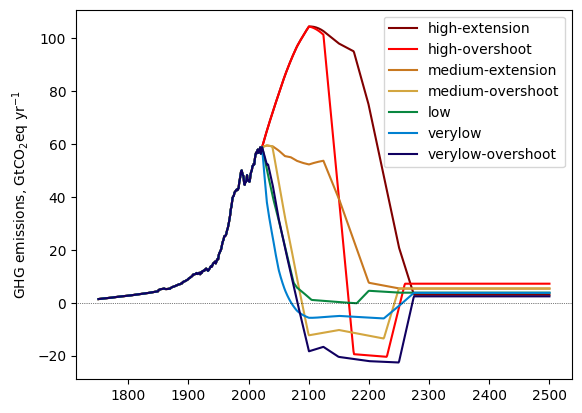

In [15]:
fig, ax = pl.subplots()
for scenario in f.scenarios:
    ax.plot(
        f.timepoints,
        co2e.sel(scenario=scenario)/ 1e6,
        label=scenario,
        color=colors[scenario]
    )
ax.set_ylabel("GHG emissions, GtCO$_2$eq yr$^{-1}$")
ax.axhline(ls=':', color='k', lw=0.5)
ax.legend();
pl.savefig('../plots/ghg_emissions.png')

In [16]:
f.fill_species_configs('../data/fair-parameters/species_configs_properties_1.4.1.csv')
f.override_defaults('../data/fair-parameters/calibrated_constrained_parameters_1.4.1.csv')
initialise(f.concentration, f.species_configs["baseline_concentration"])
initialise(f.forcing, 0)
initialise(f.temperature, 0)
initialise(f.cumulative_emissions, 0)
initialise(f.airborne_emissions, 0)
initialise(f.ocean_heat_content_change, 0)
f.run()

Running 5887 projections in parallel: 100%|██████████| 751/751 [00:41<00:00, 17.99timesteps/s]


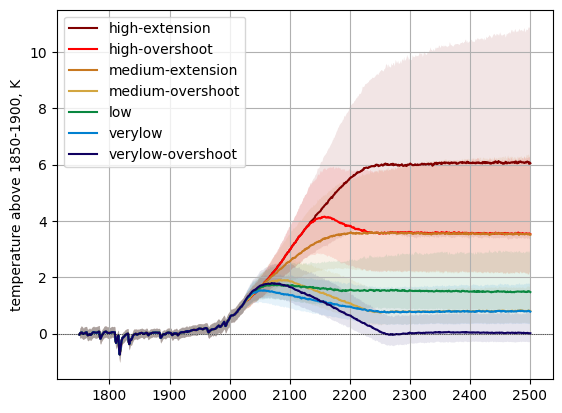

In [17]:
fig, ax = pl.subplots()
for scenario in f.scenarios:
    ax.fill_between(
        f.timebounds,
        (
            f.temperature.sel(scenario=scenario, layer=0)-
            f.temperature.sel(scenario=scenario, layer=0, timebounds=np.arange(1850,1902)).mean(dim='timebounds')
        ).quantile(0.05, dim='config'),
        (
            f.temperature.sel(scenario=scenario, layer=0)-
            f.temperature.sel(scenario=scenario, layer=0, timebounds=np.arange(1850,1902)).mean(dim='timebounds')
        ).quantile(0.95, dim='config'),
        color=colors[scenario],
        lw=0,
        alpha=0.1
    )
    ax.plot(
        f.timebounds,
        (
            f.temperature.sel(scenario=scenario, layer=0)-
            f.temperature.sel(scenario=scenario, layer=0, timebounds=np.arange(1850,1902)).mean(dim='timebounds')
        ).median(dim='config'),
        label=scenario,
        color=colors[scenario]
    )
ax.axhline(0, ls=':', color='k', lw=0.5)
ax.set_ylabel('temperature above 1850-1900, K')
ax.ylim=(-0.5, 6.5)
ax.grid()
pl.legend();
pl.savefig('../plots/temperature.png')

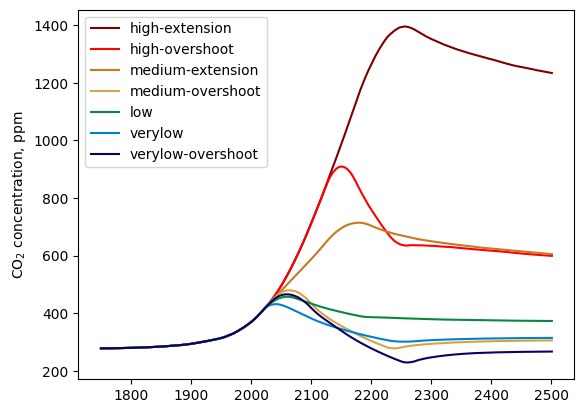

In [18]:
fig, ax = pl.subplots()
for scenario in f.scenarios:
    ax.plot(
        f.timebounds,
        f.concentration.sel(scenario=scenario, specie="CO2").median(dim='config'),
        label=scenario,
        color=colors[scenario]
    )
ax.set_ylabel('CO$_2$ concentration, ppm')
pl.legend();
pl.savefig('../plots/co2_concentration.png')

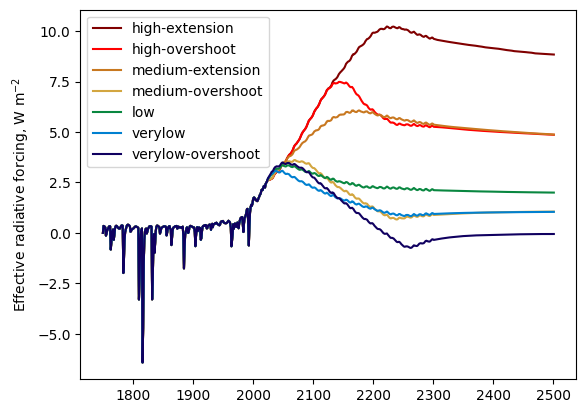

In [19]:
fig, ax = pl.subplots()
for scenario in f.scenarios:
    pl.plot(
        f.timebounds,
        f.forcing_sum.sel(scenario=scenario).median(dim='config'),
        label=scenario,
        color=colors[scenario]
    )
ax.set_ylabel('Effective radiative forcing, W m$^{-2}$')
pl.legend();
pl.savefig('../plots/forcing.png')

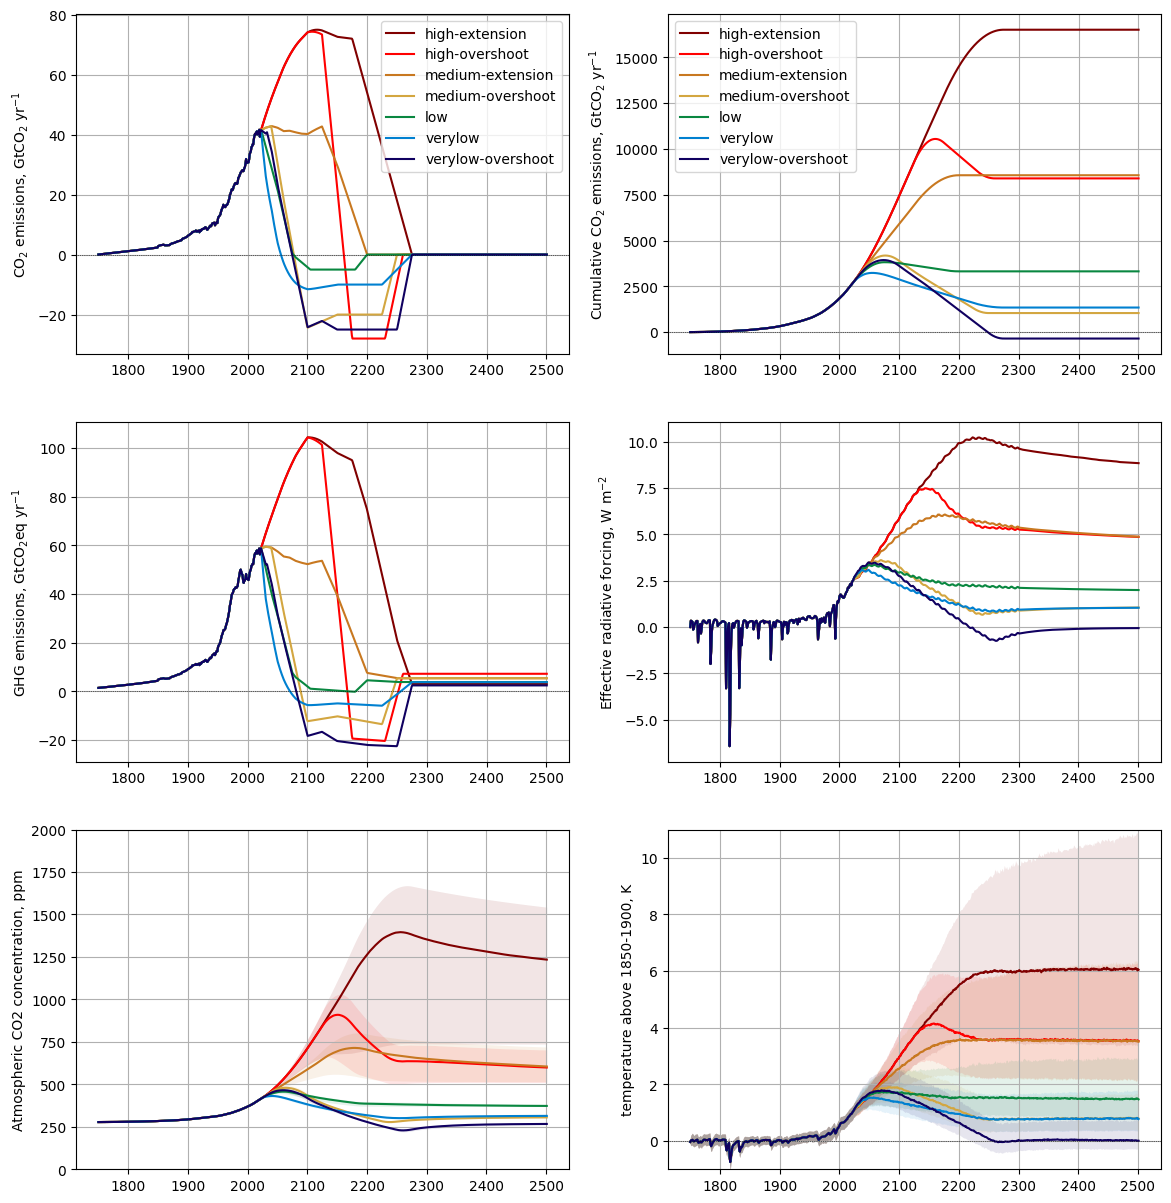

In [20]:
fig, ax = pl.subplots(nrows=3,ncols=2,figsize=(14,15))
ax=ax.flatten()
for scenario in f.scenarios:
    ax[0].plot(
        f.timepoints,
        (
            f.emissions.sel(scenario=scenario, specie="CO2 FFI", config=f.configs[0]) +
            f.emissions.sel(scenario=scenario, specie="CO2 AFOLU", config=f.configs[0])
        ),
        label=scenario,
        color=colors[scenario]
    )
ax[0].set_ylabel("CO$_2$ emissions, GtCO$_2$ yr$^{-1}$")
ax[0].axhline(ls=':', color='k', lw=0.5)
ax[0].legend()
ax[0].grid()
for scenario in f.scenarios:
    ax[1].plot(
        f.timepoints,
        (
            f.emissions.sel(scenario=scenario, specie="CO2 FFI", config=f.configs[0]) +
            f.emissions.sel(scenario=scenario, specie="CO2 AFOLU", config=f.configs[0])
        ).cumsum(),
        label=scenario,
        color=colors[scenario]
    )
ax[1].set_ylabel("Cumulative CO$_2$ emissions, GtCO$_2$ yr$^{-1}$")
ax[1].axhline(ls=':', color='k', lw=0.5)
ax[1].legend()
ax[1].grid()

for scenario in f.scenarios:
    ax[2].plot(
        f.timepoints,
        co2e.sel(scenario=scenario)/ 1e6,
        label=scenario,
        color=colors[scenario]
    )
ax[2].set_ylabel("GHG emissions, GtCO$_2$eq yr$^{-1}$")
ax[2].axhline(ls=':', color='k', lw=0.5)
#ax[2].legend()
ax[2].grid()

for scenario in f.scenarios:
    ax[3].plot(
        f.timebounds,
        f.forcing_sum.sel(scenario=scenario).median(dim='config'),
        label=scenario,
        color=colors[scenario]
    )
ax[3].set_ylabel('Effective radiative forcing, W m$^{-2}$')
#pl.legend();
ax[3].grid()

for scenario in f.scenarios:
    ax[4].fill_between(
        f.timebounds,
        (
            f.concentration.sel( specie="CO2").sel(scenario=scenario, )
        ).quantile(0.05, dim='config'),
        (
            f.concentration.sel( specie="CO2").sel(scenario=scenario)
        ).quantile(0.95, dim='config'),
        color=colors[scenario],
        lw=0,
        alpha=0.1
    )
    ax[4].plot(
        f.timebounds,
        (
            f.concentration.sel( specie="CO2").sel(scenario=scenario)
        ).median(dim='config'),
        label=scenario,
        color=colors[scenario]
    )
ax[4].axhline(0, ls=':', color='k', lw=0.5)
ax[4].set_ylabel('Atmospheric CO2 concentration, ppm')
ax[4].set_ylim(0,2000)
ax[4].grid()
for scenario in f.scenarios:
    ax[5].fill_between(
        f.timebounds,
        (
            f.temperature.sel(scenario=scenario, layer=0)-
            f.temperature.sel(scenario=scenario, layer=0, timebounds=np.arange(1850,1902)).mean(dim='timebounds')
        ).quantile(0.05, dim='config'),
        (
            f.temperature.sel(scenario=scenario, layer=0)-
            f.temperature.sel(scenario=scenario, layer=0, timebounds=np.arange(1850,1902)).mean(dim='timebounds')
        ).quantile(0.95, dim='config'),
        color=colors[scenario],
        lw=0,
        alpha=0.1
    )
    ax[5].plot(
        f.timebounds,
        (
            f.temperature.sel(scenario=scenario, layer=0)-
            f.temperature.sel(scenario=scenario, layer=0, timebounds=np.arange(1850,1902)).mean(dim='timebounds')
        ).median(dim='config'),
        label=scenario,
        color=colors[scenario]
    )
ax[5].axhline(0, ls=':', color='k', lw=0.5)
ax[5].set_ylabel('temperature above 1850-1900, K')
ax[5].set_ylim(-1, 11)
ax[5].grid()

pl.savefig('../plots/extensions.png')

In [21]:
f._ghg_indices

array([False, False,  True,  True,  True, False, False, False, False,
       False, False, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True, False, False,
       False, False, False, False, False, False, False])